In [1]:
import numpy as np
import random as rd
import math as math
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [2]:
import tensorflow

In [3]:

"""
Load the MNIST dataset into numpy arrays
Author: Alexandre Drouin
License: BSD
"""
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST data/", one_hot=True)
X_train = np.vstack([img.reshape((28, 28)) for img in mnist.train.images])
y_train = mnist.train.labels
X_test = np.vstack([img.reshape(28, 28) for img in mnist.test.images])
y_test = mnist.test.labels
del mnist

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST data/train-images-idx3-ubyte.gz
Extracting

Instructions for updating:
Please use tf.one_hot on tensors.


 MNIST data/train-labels-idx1-ubyte.gz
Extracting MNIST data/t10k-images-idx3-ubyte.gz
Extracting

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


 MNIST data/t10k-labels-idx1-ubyte.gz


In [4]:
print('shape of X train=',X_train.shape)
print('shape of y train=',y_train.shape)
print('shape of X test=',X_test.shape)
print('shape of y test=',X_test.shape)

shape of X train= (1540000, 28)
shape of y train= (55000, 10)
shape of X test= (280000, 28)
shape of y test= (280000, 28)


In [5]:
##################################################################
# reshaping numpy array into volume  for train and test set 
#################################################################
X_train=np.reshape(X_train,(-1,1,28,28))
y_train=np.reshape(y_train,(-1,10))
X_test=np.reshape(X_test,(-1,1,28,28))
y_test=np.reshape(y_test,(-1,10))
print('shape of train input volume=',X_train.shape)
print('shape of train labels=',y_train.shape)
print('shape of test input volume=',X_test.shape)
print('shape of test labels=',y_test.shape)

shape of train input volume= (55000, 1, 28, 28)
shape of train labels= (55000, 10)
shape of test input volume= (10000, 1, 28, 28)
shape of test labels= (10000, 10)


In [6]:
#############################################################
# subsample of dataset
###########################################################
X_train=X_train[0:1000,:,:,:]
y_train=y_train[0:1000,:]
X_test=X_test[0:500,:,:,:]
y_test=y_test[0:500,:]
print('shape of train input volume=',X_train.shape)
print('shape of train labels=',y_train.shape)
print('shape of test input volume=',X_test.shape)
print('shape of test labels=',y_test.shape)

shape of train input volume= (1000, 1, 28, 28)
shape of train labels= (1000, 10)
shape of test input volume= (500, 1, 28, 28)
shape of test labels= (500, 10)


In [7]:
num_data=num_train=X_train.shape[0]
num_test=X_test.shape[0]


In [8]:
# no. of convolutional layers
N_conv=2

In [9]:
def conv(num_data,C_o,W_o,H_o,x_padded,F,S,kernels,bias,output):
    for i, j in zip(range(H_o), range(W_o)):
        data_receptive_field = x_padded[:, :, i*S:i*S + F, j*S:j*S + F]
        data_receptive_field = data_receptive_field.reshape(num_data, -1)
        tmp_filter = kernels.reshape(N, -1)
        tmp_data = np.array((data_receptive_field, )*N).transpose([1, 0, 2])
        tmp_filter = np.array((tmp_filter,)*num_data)
        convolution_value = np.sum(tmp_data*tmp_filter, axis = 2)
        output[:, :, i, j] = convolution_value + bias 
    
    return output

In [10]:
########################################################
#  apply ReLU non-linearity on convolved image(output) #
#  return activation volume (output) (variables are same)                  
#########################################################
def relu_activation(num_data,N,output):
    for l in range(num_data):
        for i in range(N):
            output[l,i,:,:]=np.maximum(0,output[l,i,:,:])
    return output

In [11]:
################################################################
#   this function take input as activation volume(act_output)  #
#   and return pooled output volume (pool_output)              #
#################################################################
def pooling(num_data,C_p,W_p,H_p,pool_S,pool,act_output,pool_output):
    for i, j in zip(range(H_p), range(W_p)):
        data_receptive_field = act_output[:, :, i*pool_S:i*pool_S + pool, j*pool_S:j*pool_S + pool]
        pool_output[:, :, i, j] = data_receptive_field.max(axis = (2, 3))
           
    return pool_output

In [12]:
############################################################
#   this function take input volume and return pooled      #
#   output volume                                          #
############################################################
def convolutional_layer(S,N,F,pool,pool_S,pad,arr,kernels,bias):
    
    num_data,C,W,H=np.shape(arr)
        
    # padding of input images
    x_padded = np.pad(arr, ((0, 0), (0, 0), (pad, pad), (pad, pad)), "constant")

    #print("original input dimension =",arr.shape)
    #print("input dimension after padding=",x_padded.shape)
   
    # ouput dimension
    W_o=int(((W-F+(2*pad))/S)+1)
    H_o=int(((H-F+(2*pad))/S)+1)
    C_o=N
    output=np.zeros((num_data,C_o,W_o,H_o))
    #print("output dimension=",output.shape)
    
    # convolved output image
    output=conv(num_data,C_o,W_o,H_o,x_padded,F,S,kernels,bias,output)
    
    # activation image
    act_output=relu_activation(num_data,N,output)
    
    num_data,C_a,W_a,H_a=act_output.shape
    
    # pooled output dimension
    W_p=int(((W_a-pool)/pool_S)+1)
    H_p=int(((H_a-pool)/pool_S)+1)
    C_p=C_a
    pool_output=np.zeros((num_data,C_p,W_p,H_p))
    #print("pooled output dimension=",pool_output.shape)
    
    # pooled output image
    pooled_output=pooling(num_data,C_p,W_p,H_p,pool_S,pool,act_output,pool_output)
    
    return act_output,pooled_output

#  train data set

In [43]:
convnet_layer={} # this dictionary will store pooled ouput volume of each convolutional layers
activation_output={}
kernels={}
bias={}
W_mlp={}
b_mlp={}
losses=[]
weight=None
train_accuracy=[]
arr=X_train
num_data=X_train.shape[0]
convnet_layer[0]=arr
epoch=int(3)


In [44]:
for t in range(epoch):
    print("EPOCH--",t)
    for i in range(1,N_conv+1):
        if i==1:
            #print("CONVOLUTIONAL LAYER",i)
            # filter size
            F=5
            # no. of kernels
            N=32
            # stride
            S=1
            # padding
            pad=int((F-1)/2)
            # pooling size
            pool=2
            # pooling stride
            pool_S=2
            arra=convnet_layer[i-1]
            if t==0:
                C=convnet_layer[i-1].shape[1]
                # initializing kernels     
                kernels[1]=np.random.rand(N,C,F,F)
                # initializing biases
                bias[1]=np.zeros(N)


            activation_output[i],convnet_layer[i]=convolutional_layer(S,N,F,pool,pool_S,pad,arr=convnet_layer[i-1],kernels=kernels[i],bias=bias[i])
        if i==2:
            #print("CONVOLUTIONAL LAYER",i)
            # filter size
            F=5
            # no. of kernels
            N=64
            # stride
            S=1
            # padding
            pad=int((F-1)/2)
            # pooling size
            pool=2
            # pooling stride
            pool_S=2
            arra=convnet_layer[i-1]
            if t==0:
                C=convnet_layer[i-1].shape[1]
                # initializing kernels     
                kernels[2]=np.random.rand(N,C,F,F)
                # initializing biases
                bias[2]=np.zeros(N)


            activation_output[i],convnet_layer[i]=convolutional_layer(S,N,F,pool,pool_S,pad,arr=convnet_layer[i-1],kernels=kernels[i],bias=bias[i])
    
    #################################################################
    # unraveling
    ##################################################################
    z=convnet_layer[N_conv]
    conv_output=z
    # reshaping convolutional output into vector
    conv_vec=np.reshape(conv_output,(num_data,-1))
    #print("shape of convolutional layer output as vector=",conv_vec.shape)

    # initializing weight matrix for conversion of convolutional output into Fully connected input

    # size of input layer
    nodes=1024

    weight=1e-4*np.random.rand(conv_vec.shape[1],nodes)
    fc_in=np.dot(conv_vec,weight)  

    
    ##########################################################    
    X=fc_in
    input_size=X.shape[1]
    hidden_size=500
    output_size=10
    

    std=1e-4
    if t==0:
        W1 = std * np.random.randn(input_size, hidden_size)
        b1 = np.zeros(hidden_size)
        W2 = std * np.random.randn(hidden_size, output_size)
        b2 = np.zeros(output_size)

    relu=lambda x: np.maximum(0,x)
    h1=relu(np.dot(X,W1)+b1)
    h2=np.dot(h1,W2)+b2
    scores=h2


    ###softmax loss
    scores -=np.reshape(np.max(scores,axis=1),(num_data,1))
    p = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    index_correct_class=[range(num_data),np.argmax(y_train,axis=1)] #indexes of correct class
    correct_class_score= np.reshape(p[index_correct_class[0],index_correct_class[1]],(num_data,1))

    loss = np.sum(-np.log(correct_class_score))
    loss /= num_data
    
    reg=5e-6
    loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
    print("loss=",loss)
    losses=np.append(losses,loss)
    #print("size of output vector=",p.shape) 
    
    ###############################################################################################3
    # Backward pass: compute gradients
    grads = {}
    # gradient on scores
    dscores=p
    dscores[index_correct_class] -=1
    dscores/=num_data

    #gradient on W2
    grads['W2']=np.dot(h1.T,dscores)
    #gradient on b2
    grads['b2']=np.sum(dscores,axis=0)

    #backprop to hidden layer
    dhidden= np.dot(dscores, W2.T)
    dhidden[h1 <=0] =0

    #gradient on W2
    grads['W1']= np.dot(X.T,dhidden)
    #gradient on b2
    grads['b1']=np.sum(dhidden,axis=0)


    #adding regularization
    grads['W2']+=reg*W2
    grads['W1']+=reg*W1

    learning_rate=1e-1

    # updating parameters
    W1 -=learning_rate*grads['W1']
    W2 -=learning_rate*grads['W2']
    b1 -=learning_rate*grads['b1']
    b2 -=learning_rate*grads['b2']
    W_mlp[1]=W1
    W_mlp[2]=W2
    b_mlp[1]=b1
    b_mlp[2]=b2

    # training accuracy
    train_acc = (np.argmax(h2,1) == np.argmax(y_train,1)).mean()
    print('training accuracy',train_acc)
    train_accuracy=np.append(train_accuracy,train_acc)
    #val_acc = (self.predict(X_val) == y_val).mean()
    
    #########################################################################
    # backpropagation in unravel
    dX= np.dot(dhidden,W1.T)
    grads['weight']=np.dot(conv_vec.T,dX)


    dconv_vec=np.dot(dX,weight.T)

    weight -=learning_rate*grads['weight']
    dconv_vec=np.reshape(dconv_vec,(conv_output.shape))
    #print(dconv_vec.shape)
    
    ##############################################################################
    
    #############################################################################
    #   pooling backward pass  in convolutional layer 2                         #
    #############################################################################
    dact2 = None
    # pooling size
    pool=2
    # pooling stride
    pool_S=2
    N, C, H, W = activation_output[2].shape

    H_prime = int((H + - pool)/pool_S + 1)
    W_prime = int((W + - pool)/pool_S + 1)

    q=activation_output[2]
    dact2 = np.zeros_like(activation_output[2])


    for i, j in zip(range(H_prime),range(W_prime)):
        data_receptive_field = q[:, :, i*pool_S:i*pool_S + pool, j*pool_S:j*pool_S + pool]

        data_roll = data_receptive_field.reshape(N*C, -1)
        data_maxgrad = (data_roll == np.row_stack(data_roll.max(axis = 1))).astype("int")
        grad_term = (data_maxgrad*dconv_vec[:, :, i, j].reshape(N*C, 1)).reshape(N, C, pool, pool)

        dact2[:, :, i*pool_S:i*pool_S + pool, j*pool_S:j*pool_S + pool] += grad_term

    ############################################################################################################
    dx2, dw2, db2 = None, None, None
    #############################################################################
    #  convolutional backward pass in convolutional layer 2                     #
    #############################################################################
    # filter size
    f=5

    # stride
    S=1
    # padding
    pad=int((f-1)/2)

    N, C, H, W = convnet_layer[1].shape
    F, _, HH, WW = kernels[2].shape
    H_prime =int((H + 2*pad - HH)/S + 1)
    W_prime = int((W + 2*pad - WW)/S + 1)
    dx2 = np.zeros_like(convnet_layer[1])
    dw2 = np.zeros_like(kernels[2])
    db2 = np.zeros_like(bias[2])

    # Zero padding on x
    x2_padded = np.pad(convnet_layer[1], ((0, 0), (0, 0), (pad, pad), (pad, pad)), "constant")
    dx2_padded = np.zeros_like(x2_padded)

    # Derivative for db2
    db2 = np.sum(dact2, axis = (0, 2, 3)) # only remain axis for F, diffrent filters

    for i, j in zip(range(H_prime), range(W_prime)):
        data_receptive_field = x2_padded[:, :, i*S:i*S + HH, j*S:j*S + WW]

        # Derivative for dw2
        tmp_field = np.array((data_receptive_field,)*F).transpose([1, 0, 2, 3, 4]).reshape(N*F, -1)
        dw_tmp = (tmp_field*dact2[:, :, i, j].reshape(N*F, 1)).reshape(N, F, C, HH, WW)
        dw2 += dw_tmp.sum(axis = 0)

        # Derivative for dx2
        tmp_filter = np.array((kernels[2],)*N).reshape(N*F, -1)
        dx_tmp = (tmp_filter*dact2[:, :, i, j].reshape(N*F, 1)).reshape(N, F, C, HH, WW)
        dx2_padded[:, :, i*S:i*S + HH, j*S:j*S + WW] += dx_tmp.sum(axis = 1)
    # Unpad for dx
    dx2 = dx2_padded[:, :, 1:-1, 1:-1]

    kernels[2] += dw2
    bias[2] += db2
    
    ####################################################################################################3
    #############################################################################
    #   pooling backward pass  in convolutional layer 1                         #
    #############################################################################
    dact1 = None
    # pooling size
    pool=2
    # pooling stride
    pool_S=2
    N, C, H, W = activation_output[1].shape

    H_prime = int((H + - pool)/pool_S + 1)
    W_prime = int((W + - pool)/pool_S + 1)

    q=activation_output[1]
    dact1 = np.zeros_like(activation_output[1])


    for i, j in zip(range(H_prime),range(W_prime)):
        data_receptive_field = q[:, :, i*pool_S:i*pool_S + pool, j*pool_S:j*pool_S + pool]

        data_roll = data_receptive_field.reshape(N*C, -1)
        data_maxgrad = (data_roll == np.row_stack(data_roll.max(axis = 1))).astype("int")
        grad_term = (data_maxgrad*dx2[:, :, i, j].reshape(N*C, 1)).reshape(N, C, pool, pool)

        dact1[:, :, i*pool_S:i*pool_S + pool, j*pool_S:j*pool_S + pool] += grad_term
        
    ##############################################################################################
    dx1, dw1, db1 = None, None, None
    #############################################################################
    #  convolutional backward pass in convolutional layer 1                     #
    #############################################################################

    # filter size
    f=5

    # stride
    S=1
    # padding
    pad=int((f-1)/2)

    N, C, H, W = convnet_layer[0].shape
    F, _, HH, WW = kernels[1].shape
    H_prime = int((H + 2*pad - HH)/S + 1)
    W_prime = int((W + 2*pad - WW)/S + 1)
    dx1 = np.zeros_like(convnet_layer[0])
    dw1 = np.zeros_like(kernels[1])
    db1 = np.zeros_like(bias[1])

    # Zero padding on x1
    x1_padded = np.pad(convnet_layer[0], ((0, 0), (0, 0), (pad, pad), (pad, pad)), "constant")
    dx1_padded = np.zeros_like(x1_padded)

    # Derivative for db1
    db1 = np.sum(dact1, axis = (0, 2, 3)) # only remain axis for F, diffrent filters

    for i, j in zip(range(H_prime), range(W_prime)):
        data_receptive_field = x1_padded[:, :, i*S:i*S + HH, j*S:j*S + WW]

        # Derivative for dw1
        tmp_field = np.array((data_receptive_field,)*F).transpose([1, 0, 2, 3, 4]).reshape(N*F, -1)
        dw_tmp = (tmp_field*dact1[:, :, i, j].reshape(N*F, 1)).reshape(N, F, C, HH, WW)
        dw1 += dw_tmp.sum(axis = 0)

        # Derivative for dx1
        tmp_filter = np.array((kernels[1],)*N).reshape(N*F, -1)
        dx_tmp = (tmp_filter*dact1[:, :, i, j].reshape(N*F, 1)).reshape(N, F, C, HH, WW)
        dx1_padded[:, :, i*S:i*S + HH, j*S:j*S + WW] += dx_tmp.sum(axis = 1)
    # Unpad for dx1
    dx1 = dx1_padded[:, :, 1:-1, 1:-1]


    kernels[1] += dw1
    bias[1] += db1



EPOCH-- 0
loss= 2.30258406994
training accuracy 0.093
EPOCH-- 1
loss= 2.30241495534
training accuracy 0.115
EPOCH-- 2
loss= 2.30216137089
training accuracy 0.115


# test data set

In [45]:
convnet_layer={} # this dictionary will store pooled ouput volume of each convolutional layers
activation_output={}

test_losses=[]
test_accuracy=[]
arr=X_test
num_data=X_test.shape[0]
convnet_layer[0]=arr


W1 = W_mlp[1]
b1 = b_mlp[1]
W2 = W_mlp[2]
b2 = b_mlp[2]

for i in range(1,N_conv+1):
    if i==1:
        #print("CONVOLUTIONAL LAYER",i)
        # filter size
        F=5
        # no. of kernels
        N=32
        # stride
        S=1
        # padding
        pad=int((F-1)/2)
        # pooling size
        pool=2
        # pooling stride
        pool_S=2
        arra=convnet_layer[i-1]
        activation_output[i],convnet_layer[i]=convolutional_layer(S,N,F,pool,pool_S,pad,arr=convnet_layer[i-1],kernels=kernels[i],bias=bias[i])
    if i==2:
        #print("CONVOLUTIONAL LAYER",i)
        # filter size
        F=5
        # no. of kernels
        N=64
        # stride
        S=1
        # padding
        pad=int((F-1)/2)
        # pooling size
        pool=2
        # pooling stride
        pool_S=2
        arra=convnet_layer[i-1]
        activation_output[i],convnet_layer[i]=convolutional_layer(S,N,F,pool,pool_S,pad,arr=convnet_layer[i-1],kernels=kernels[i],bias=bias[i])
    
#################################################################
# unraveling
##################################################################
z=convnet_layer[N_conv]
conv_output=z
# reshaping convolutional output into vector
conv_vec=np.reshape(conv_output,(num_data,-1))
    
# size of input layer
nodes=1024
fc_in=np.dot(conv_vec,weight)  

##########################################################    
X=fc_in
input_size=X.shape[1]
hidden_size=500
output_size=10

relu=lambda x: np.maximum(0,x)
h1=relu(np.dot(X,W1)+b1)
h2=np.dot(h1,W2)+b2
scores=h2


###softmax loss
scores -=np.reshape(np.max(scores,axis=1),(num_data,1))
p = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
index_correct_class=[range(num_data),np.argmax(y_test,axis=1)] #indexes of correct class
correct_class_score= np.reshape(p[index_correct_class[0],index_correct_class[1]],(num_data,1))

loss = np.sum(-np.log(correct_class_score))
loss /= num_data
    
reg=5e-6
loss += reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
print("testing loss=",loss)

    
# training accuracy
test_acc = (np.argmax(h2,1) == np.argmax(y_test,1)).mean()
print('testing accuracy',test_acc)

    
    
   



testing loss= 2.30249386659
testing accuracy 0.09


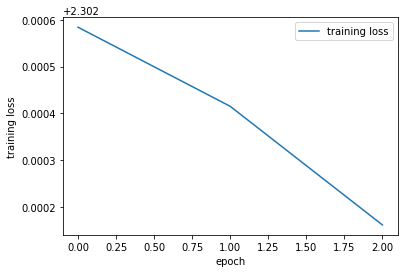

In [46]:

plt.plot(range(epoch),losses,label='training loss')
plt.xlabel('epoch')
plt.ylabel('training loss')
plt.legend()

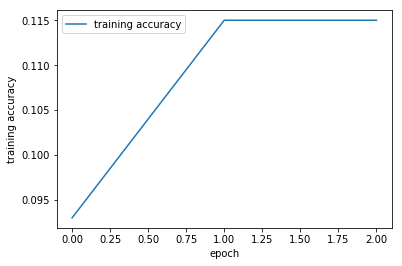

In [47]:
plt.plot(range(epoch),train_accuracy,label='training accuracy')
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.legend()